In [2]:
# use !pip install geopandas and !pip install descartes in the notebook if not yet installed. 

# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# GIS libraries
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
from shapely.geometry import Point, MultiPoint, MultiPolygon
from descartes.patch import PolygonPatch

# Machine learning libraries
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression

from sklearn.model_selection import cross_val_predict

from scikitplot.metrics import plot_confusion_matrix, plot_roc

# Libraries to build a toggle
from IPython.display import HTML
pd.set_option('max_columns', 140)

toggle = HTML('''<script>code_show=true; function code_toggle() {
if (code_show){$('div.input').hide();} else {$('div.input').show();}
code_show = !code_show} $( document ).ready(code_toggle);</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

#toggle
toggle

# Geospatial Information in Data Science
By Mycchaka Kleinbort and Marijse van den Berg 

    mycchaka.kleinbort@capgemini.com
    marijse.van-den-berg@capgemini.com

# Business Problem

A hypothetical retail store client approached Capgemini with the following problem:


> "Where should we open new stores?"







For more context
> The client has thousands of stores across the UK, and they track several metrics including square footage, rent cost, average sales per customer, foot traffic amongst others. With Capgemini's help they hope to understand what factors drive the success of a store, so that they can plan new locations with a better understanding of the store's expected performance.


# What makes this project successful?

- Client engagement 
- Trust in the results
- Feasibility - Can the solution be implemented?
- Can be understood by the non-technical stakeholders
- Tangible benefit to the business
- Growth of the client relationship

# Our approach: Building a model

If we can build a model that predicts the success of a store at a given location, the client could use this tool to asses venue locations, negotiate on pricing and optimize their resources.

# The Steps we take


### 1. Data Collection
    We gather relevant data from throughout the organization as well as 
    publicly available data.

### 2. Data Consolidation
    We link up different data sources and create a master dataset.
    
### 3. EDA
    We perform exploratory data analysis to understand where current stores 
    are located and what other landmarks they are closely related to. 
    We also explore store characteristics like size. 
    


### 4. Feature Engineering
    With our newly gained understanding of the business and available data, 
    we carefully think around relevant features that might help us describe the problem. 
    
### 5. Target Definition
    We define a target variable that describes the success of a store.
    
### 6. Model Building
    We build a model that accurately predicts success of current stores and 
    look at feature importances generated by this model. 
    
### 7. Evaluation
    We test our hypothesis generated by the model with business stakeholders 
    and present our final conclusions. 



# The Data

We will be using four data sources:
- A list of 13,859 supermaket locations across the UK

        https://geolytix.co.uk/?retail_points
    
- A dataset of regional boundaries sourced from Ordinace Survey

        https://www.ordnancesurvey.co.uk/
        
- A building polygon dataset, also from Ordinance Survey

        https://www.ordnancesurvey.co.uk/
        
- Google review data

        https://www.google.co.uk/maps

In [3]:
# Loading the data
data_stores = pd.read_csv('data/Store Data/geolytix_retailpoints_version12_oct18.txt', sep='\t')
data_regions = gpd.read_file('data/Regional Boundaries/district_borough_unitary_region.dbf')
data_buildings = pd.read_pickle('data/tmp/BirminghamBuildings.p')

# The Stores dataset

In [3]:
data_stores.head(3)

,id,retailer,fascia,store_name,add_one,add_two,town,locality,postcode,long_wgs,lat_wgs,bng_e,bng_n,pqi,open_date,close_date,size_band,size_sqft,size_sqm
0,1010000001,Aldi,Aldi,Aldi Aberdeen,Unit 9-10 Boulevard Retail Park,NaN,Aberdeen,Central Aberdeen,AB11 5EJ,-2.081728,57.148626,395153.81,806418.66,Rooftop geocoded by Geolytix,0,0,"3,013 < 15,069 ft2 (280 < 1,400 m2)","Between 3,013 and 15,069","Between 280 and 1,400"
1,1010000002,Aldi,Aldi,Aldi Westhill,Westhill Drive,NaN,Westhill,NaN,AB32 6FY,-2.278341,57.154810,383260.14,807138.54,Rooftop geocoded by Geolytix,0,0,"3,013 < 15,069 ft2 (280 < 1,400 m2)","Between 3,013 and 15,069","Between 280 and 1,400"
2,1010000003,Aldi,Aldi,Aldi Ellon,Ythan Terrace,NaN,Ellon,NaN,AB41 9LJ,-2.075009,57.363314,395586.81,830317.99,Rooftop geocoded by Geolytix,0,0,"3,013 < 15,069 ft2 (280 < 1,400 m2)","Between 3,013 and 15,069","Between 280 and 1,400"


# Store Regions

In [4]:
data_regions.head(3)

,NAME,AREA_CODE,DESCRIPTIO,FILE_NAME,NUMBER,NUMBER0,POLYGON_ID,UNIT_ID,CODE,HECTARES,AREA,TYPE_CODE,DESCRIPT0,TYPE_COD0,DESCRIPT1,geometry
0,Barnsley District (B),MTD,Metropolitan District,BARNSLEY_DISTRICT_(B),1,1,50242,9182,E08000016,32907.759,0.0,AA,CIVIL ADMINISTRATION AREA,None,None,"POLYGON ((413272.6025 398268.6962, 413275.4966..."
1,Birmingham District (B),MTD,Metropolitan District,BIRMINGHAM_DISTRICT_(B),2,2,40111,18,E08000025,26779.106,0.0,AA,CIVIL ADMINISTRATION AREA,None,None,"POLYGON ((400009.3004 276168.7969, 400000 2761..."
2,Bolton District (B),MTD,Metropolitan District,BOLTON_DISTRICT_(B),3,3,56602,18832,E08000001,13979.204,0.0,AA,CIVIL ADMINISTRATION AREA,None,None,"POLYGON ((376603.6992 403343.0037, 376601.5967..."


# Store Buildings

In [5]:
data_buildings.head(3)

,ID,FEATCODE,geometry
211314,90F86184-53D3-4622-951F-4F6A273FB2BA,15014,"POLYGON Z ((415763.03 297415.07 0, 415755.39 2..."
211337,9B05FCF1-92BA-4D80-894E-7893CCE5B36A,15014,"POLYGON Z ((415390.22 296665.21 0, 415394.25 2..."
211339,FE1320F4-0283-4973-AF0C-2F9858837225,15014,"POLYGON Z ((415415.34 296669.53 0, 415413.07 2..."


In [6]:
# The data we read from RetailPoints is a simple pandas dataframe, this makes it into a GeoDataFrame
data_stores = gpd.GeoDataFrame(data_stores.assign(geometry = lambda x: x.apply(lambda x: Point(x['bng_e'], x['bng_n']), axis=1)))

A Picture is worth a thousand words:

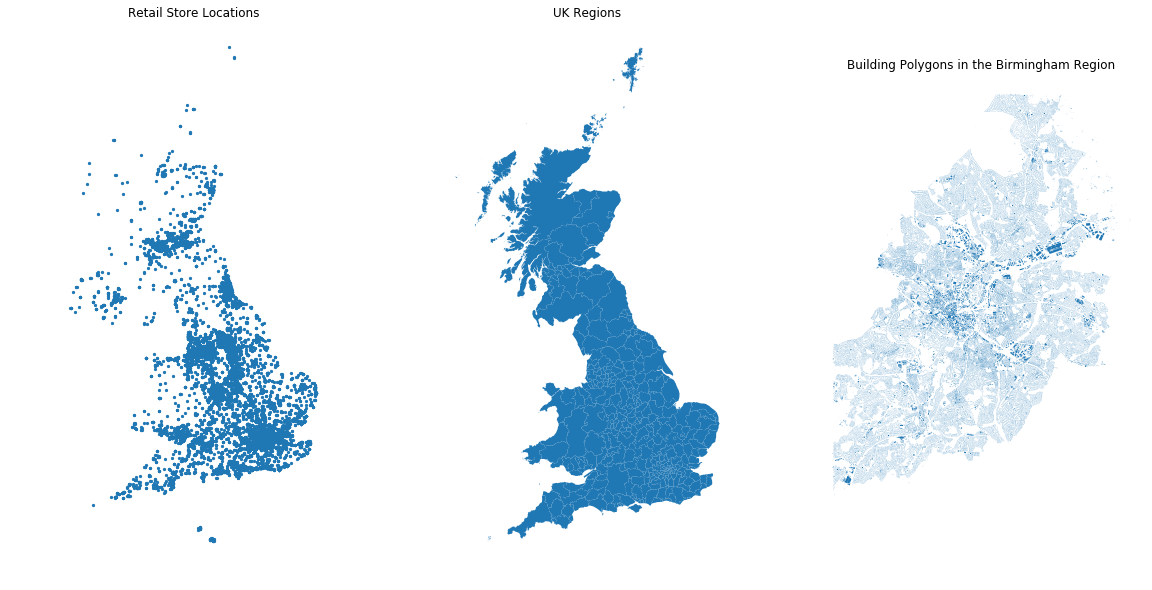

In [7]:
fig, axes  = plt.subplots(ncols=3, nrows=1)
fig.set_size_inches(20,10)

# Stores Dataset
data_stores.plot(ax=axes[0], markersize=5)
axes[0].set_title('Retail Store Locations')

# Region Outlines
data_regions.plot(ax=axes[1])
axes[1].set_title('UK Regions')

# Buildings in the Birmingham Area
data_buildings.plot(ax=axes[2])
axes[2].set_title('Building Polygons in the Birmingham Region')

for ax in axes:
    ax.set_axis_off()
    
plt.show()

# Google Maps Store Reviews

In [8]:
target = pd.read_csv('data/target.csv', usecols=['id', 'store_reviews','store_score'])
target.head()

,id,store_reviews,store_score
0,1010000006,931 reviews,4.0
1,1010000007,894 reviews,4.1
2,1010000008,617 reviews,4.1
3,1010000009,743 reviews,4.2
4,1010000010,636 reviews,4.2


In [9]:
def clean_review(x):
    if x is None or type(x)==int:
        return x
    else:
        return int(x.split()[0].replace(',',''))

target['store_reviews'] = target['store_reviews'].apply(clean_review)

target.head()

,id,store_reviews,store_score
0,1010000006,931,4.0
1,1010000007,894,4.1
2,1010000008,617,4.1
3,1010000009,743,4.2
4,1010000010,636,4.2


# Focusing on the Birmingham Area

### Why
By reducing the scope of the project you can develop deeper expertise on the data, and you can often engage the business better if you can make your analysis tangible to them.


### How
The Region Polygon dataset from OS contains the boundary for the Birmingham region. Here we will just consider stores and other things that lie within this polygon.

In [10]:
# The following is the polygonal boundary of the country of Birmingham
def filter_to_polygon(df, poly):
    return df.loc[df.intersects(poly), :]

In [11]:
birmingham_polygon = data_regions.loc[1,'geometry'] # the polygon for birmingham

data_stores = filter_to_polygon(data_stores, birmingham_polygon)

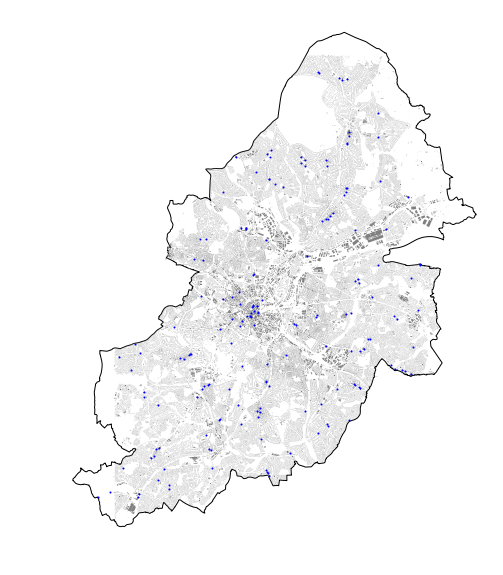

In [12]:
ax = data_regions.loc[[1]].plot(figsize=(10,10), color='white', edgecolor='k')
data_buildings.plot(ax=ax, color='gray')
data_stores.plot(ax=ax, markersize=1, edgecolor='b')
ax.set_axis_off()
plt.show()

In [13]:
data_stores = data_stores.merge(target)
data_stores.head(2)

,id,retailer,fascia,store_name,add_one,add_two,town,locality,postcode,long_wgs,lat_wgs,bng_e,bng_n,pqi,open_date,close_date,size_band,size_sqft,size_sqm,geometry,store_reviews,store_score
0,1010000006,Aldi,Aldi,Aldi Sparkbrook Birmingham,273 Stratford Road,Sparkbrook,Birmingham,Sparkbrook,B11 1QS,-1.872444,52.459726,408764.05,284649.62,Rooftop geocoded by Geolytix,0,0,"3,013 < 15,069 ft2 (280 < 1,400 m2)","Between 3,013 and 15,069","Between 280 and 1,400",POINT (408764.05 284649.62),931,4.0
1,1010000007,Aldi,Aldi,Aldi Warstock Birmingham,Alcester Road,Maypole Lane,Birmingham,Warstock,B14 5JE,-1.886342,52.405415,407829.25,278606.87,Rooftop geocoded by Geolytix,0,0,"15,069 < 30,138 ft2 (1,400 < 2,800 m2)","Between 15,069 and 30,138","Between 1,400 and 2,800",POINT (407829.25 278606.87),894,4.1


# Data exploration

The goal of this step is to better understand the data, and to get start getting a few insights. 

Today we will only look at the impact on railway stations on store success, but given more time one might also consider
- Bus stops
- Population density
- Schools
- Rent prices
- Size of parking lot 
- Opening hours

# Ad Hoc EDA


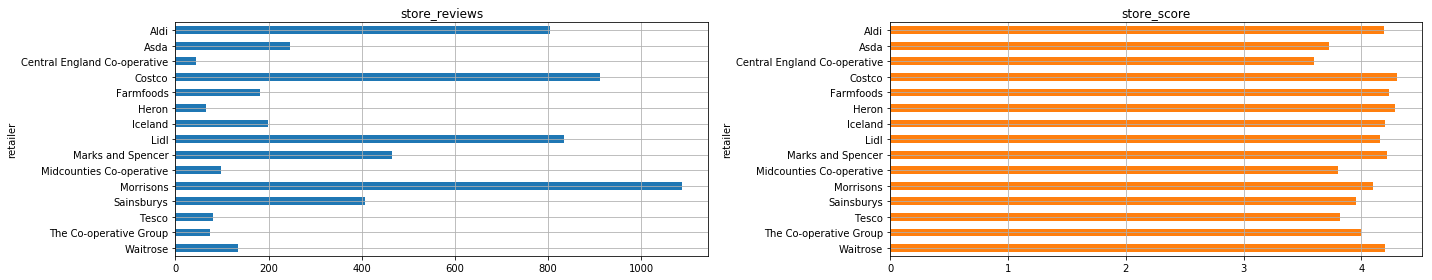

In [14]:
(data_stores
 .groupby('retailer')[['store_reviews','store_score']]
 .mean()
 .sort_index(ascending=False)
 .plot(kind='barh', subplots=True, layout=(1,2), figsize=(20,4), sharex=False, legend=False, grid=True)
)

plt.tight_layout()

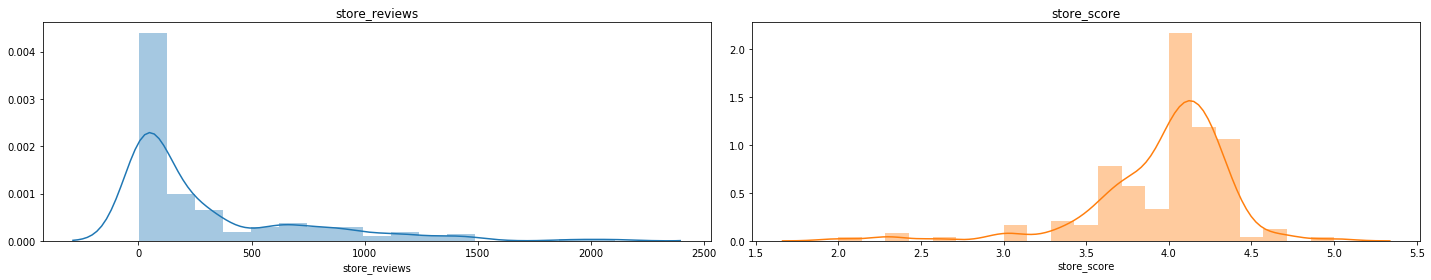

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(20,4)

sns.distplot(data_stores['store_reviews'], ax=axes[0], color=plt.cm.tab10.colors[0])
axes[0].set_title('store_reviews')

sns.distplot(data_stores['store_score'], ax=axes[1], color=plt.cm.tab10.colors[1])
axes[1].set_title('store_score')


    
plt.tight_layout()


# How do Railway Locations affect Stores?

In [16]:
# Read file with square coordinates
# filter_to_polygon gives intersection of birmingham map and RailWayStations
data_railways = filter_to_polygon(gpd.read_file('data/OS Local Map/SP_RailwayStation.dbf'), birmingham_polygon)

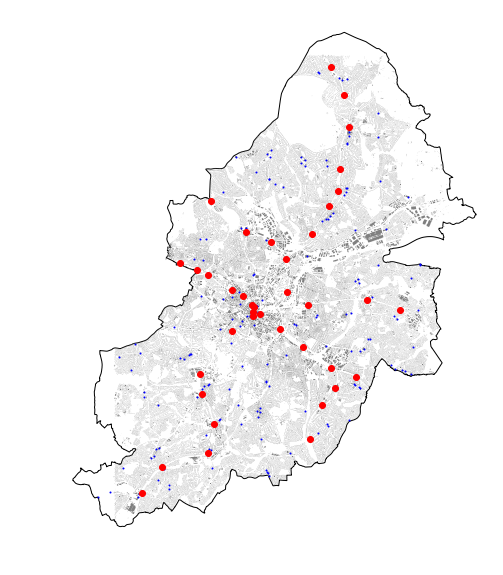

In [17]:
# Plotting the data
ax = data_regions.loc[[1]].plot(figsize=(10,10), color='white', edgecolor='k')
data_buildings.plot(ax=ax, color='gray')
data_stores.plot(ax=ax, markersize=1, edgecolor='b')
data_railways.plot(ax=ax, color='r')

ax.set_axis_off()

plt.show()

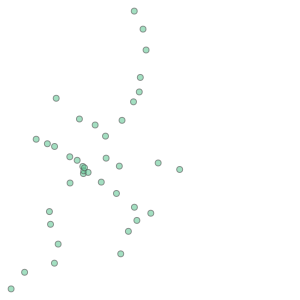

In [18]:
# Look at distances between railway stations
railways = MultiPoint(data_railways['geometry'].values)
railways


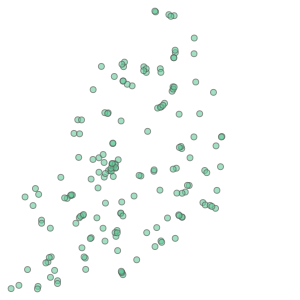

In [19]:
stores = MultiPoint(data_stores['geometry'].values)
stores


We can enrich our dataset with the distance of each store to the nearest railway station

In [20]:
data_stores['distance_to_railway_station'] = data_stores.distance(railways)
data_stores.head(3)

,id,retailer,fascia,store_name,add_one,add_two,town,locality,postcode,long_wgs,lat_wgs,bng_e,bng_n,pqi,open_date,close_date,size_band,size_sqft,size_sqm,geometry,store_reviews,store_score,distance_to_railway_station
0,1010000006,Aldi,Aldi,Aldi Sparkbrook Birmingham,273 Stratford Road,Sparkbrook,Birmingham,Sparkbrook,B11 1QS,-1.872444,52.459726,408764.05,284649.62,Rooftop geocoded by Geolytix,0,0,"3,013 < 15,069 ft2 (280 < 1,400 m2)","Between 3,013 and 15,069","Between 280 and 1,400",POINT (408764.05 284649.62),931,4.0,992.505699
1,1010000007,Aldi,Aldi,Aldi Warstock Birmingham,Alcester Road,Maypole Lane,Birmingham,Warstock,B14 5JE,-1.886342,52.405415,407829.25,278606.87,Rooftop geocoded by Geolytix,0,0,"15,069 < 30,138 ft2 (1,400 < 2,800 m2)","Between 15,069 and 30,138","Between 1,400 and 2,800",POINT (407829.25 278606.87),894,4.1,2772.315293
2,1010000008,Aldi,Aldi,Aldi Aston Birmingham,High Street,Newtown,Birmingham,Aston,B19 2SS,-1.896935,52.496752,407094.15,288765.55,Rooftop geocoded by Geolytix,0,0,"3,013 < 15,069 ft2 (280 < 1,400 m2)","Between 3,013 and 15,069","Between 280 and 1,400",POINT (407094.15 288765.55),617,4.1,1189.968978


## Different ways to frame the problem

One of the major challenges of data science is finding the right perspective from which to observe the data.

For example, when seeking to predict a store's success, we need to consider what matters most
- Should we focus on the average distance between stores and their closest stations?
- Should we focus on the average distance between the rail network and the closest stores?
- Should we simply assume each person will go to the closest store when exiting the train?



# Option 1: Mean Distance From Retailer to Rail Network

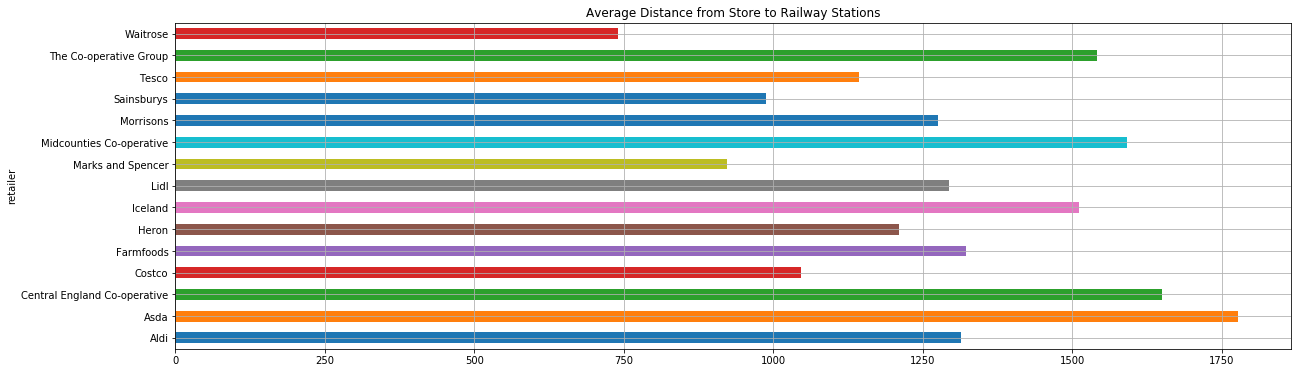

In [21]:
(data_stores
 .groupby('retailer')['distance_to_railway_station']
 .mean()
 .sort_index()
 .plot(kind='barh', title='Average Distance from Store to Railway Stations', figsize=(20,6), grid=True)
)

plt.show()

# Option 2: Mean Distance From  Rail Network to Retailer

In [22]:
x = data_stores.groupby('retailer').apply(lambda x: MultiPoint(x['geometry'].values))
x = gpd.GeoSeries(x)

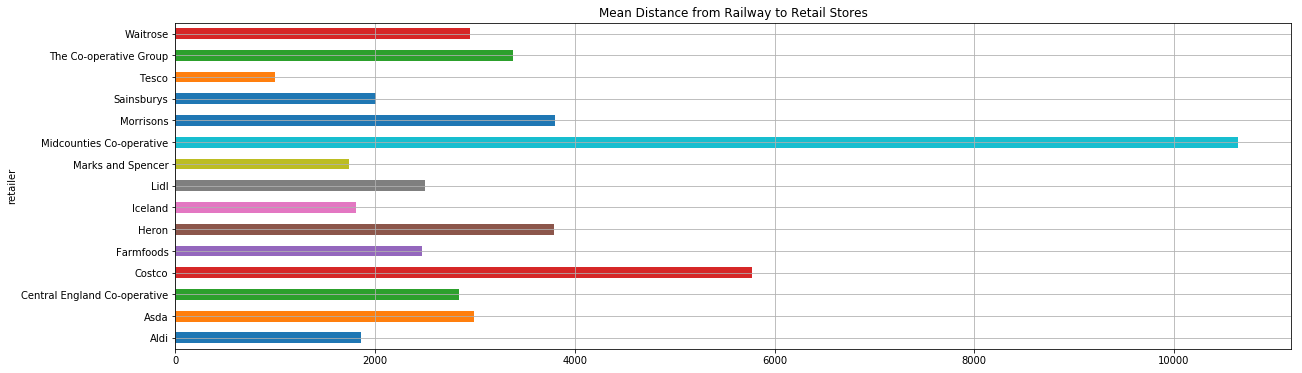

In [23]:
distance_from_railway = data_railways.apply(lambda station: x.distance(station['geometry']), axis=1)

(distance_from_railway
 .mean()
 .sort_index()
 .plot(kind='barh', title='Mean Distance from Railway to Retail Stores', figsize=(20,6), grid=True)
)
plt.show()

# Option 3: Which Retailer is closest to any one Station?

In [24]:
# Ranks stores based on proximity to station for every station out there. 
(distance_from_railway
 .apply(lambda x: x.argsort().argsort(), axis=1)
).head()

retailer,Aldi,Asda,Central England Co-operative,Costco,Farmfoods,Heron,Iceland,Lidl,Marks and Spencer,Midcounties Co-operative,Morrisons,Sainsburys,Tesco,The Co-operative Group,Waitrose
10,6,8,11,13,7,5,1,0,4,14,10,9,2,3,12
11,4,10,12,13,5,9,1,0,7,14,8,6,2,3,11
12,2,11,7,13,9,10,5,12,3,14,8,1,0,6,4
13,4,11,12,13,5,10,0,1,9,14,8,6,2,3,7
14,8,4,0,10,9,5,6,7,3,14,13,12,2,1,11


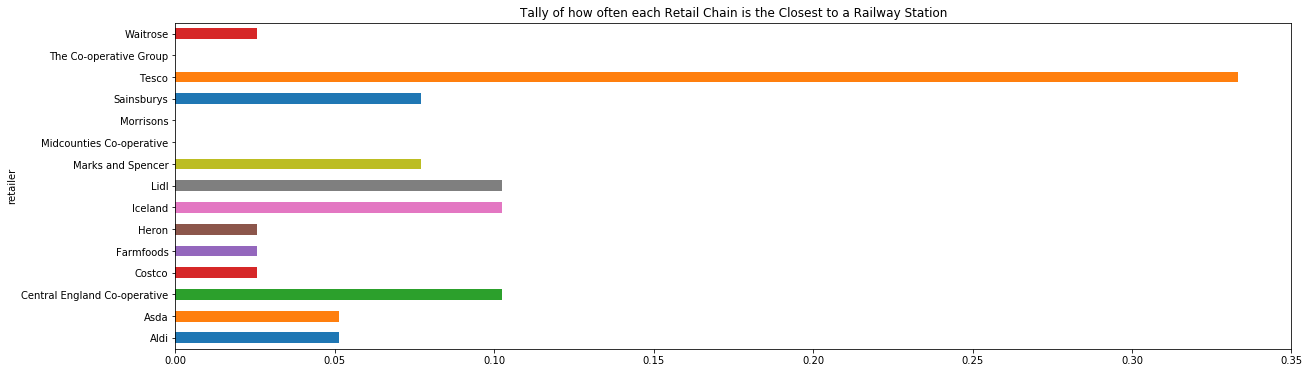

In [25]:
(distance_from_railway
 .apply(lambda x: x.argsort().argsort(), axis=1)
 .applymap(lambda x: x==0)
.mean()
.sort_index()
).plot(kind='barh', title='Tally of how often each Retail Chain is the Closest to a Railway Station', figsize=(20,6))

plt.show()
# averages columns of each store if 0 = True (1) and if not zero = False (0). So averages of columsn with 0's and 1's. 

# Creating features

# Steps
1. Match each store to its building
2. Find the perimeter and area for each store
3. Find the stores closest 

# Finding the matching buildings

In [26]:
probable_buildings = data_buildings[data_buildings['geometry'].distance(stores)<100]

In [27]:
# To be able to create features we link building polygon to store name
data_stores['building_poly'] = (data_stores['geometry'].apply(lambda p: 
                                          probable_buildings.loc[
                                              probable_buildings.intersects(p).idxmax(), 'geometry'
                                          ])
                                   )

    data_stores['building_poly'] = (
               data_stores['geometry'].apply(lambda p: 
                      probable_buildings.loc[
                          probable_buildings.intersects(p).idxmax(), 'geometry'
                      ])
               )

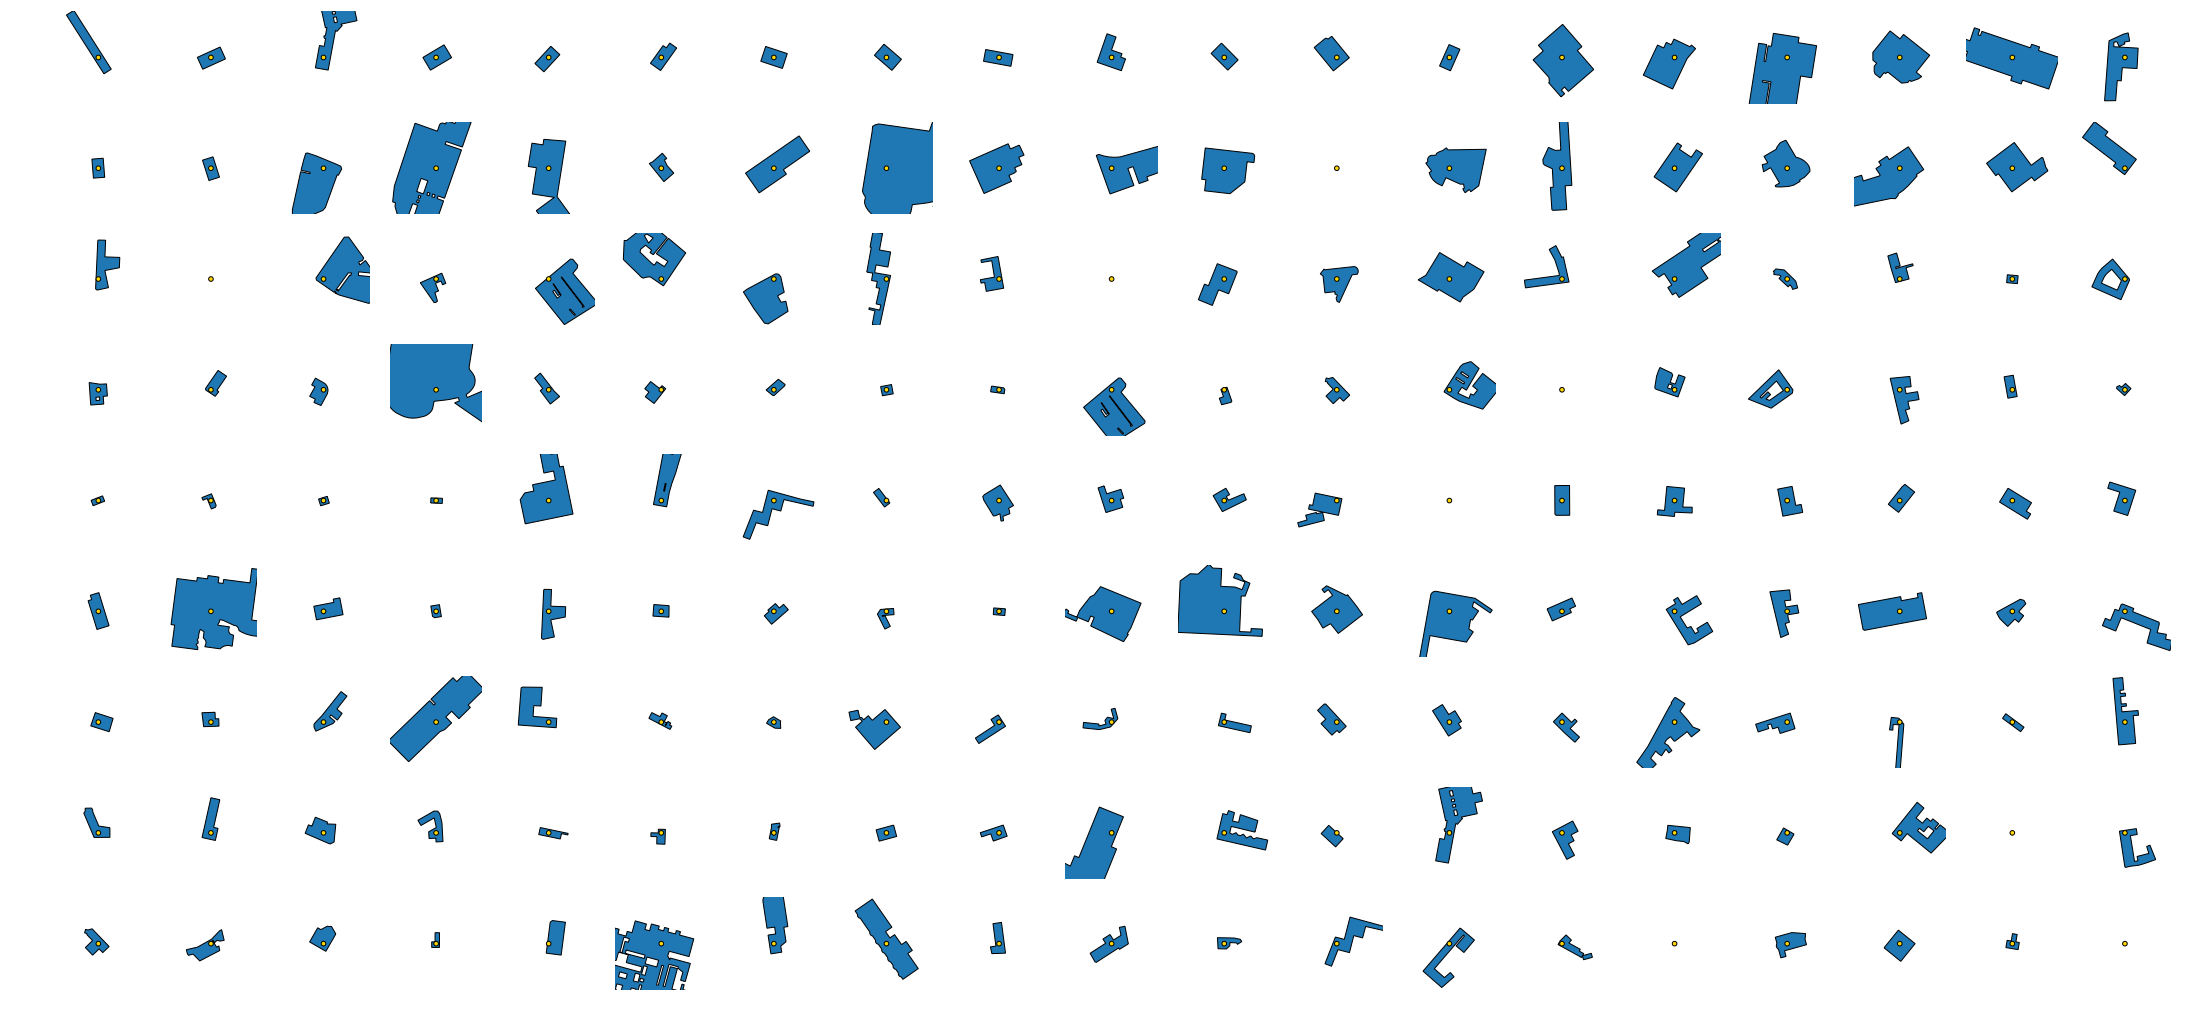

In [28]:
fig, axes = plt.subplots(9,19)
fig.set_size_inches(19*2, 9*2)

for i, ax in enumerate(axes.ravel()):
    
    if i < len(data_stores):
        ax.add_patch(PolygonPatch(data_stores.iloc[i]['building_poly']))
        ax.add_patch(PolygonPatch(data_stores.iloc[i]['geometry'].buffer(5), fc='gold'))

        xmin, ymin, xmax, ymax = data_stores.iloc[i]['geometry'].buffer(100).bounds
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)


    ax.set_aspect('equal', 'box')
    ax.set_axis_off()


In [29]:
data_stores = data_stores[data_stores.apply(lambda row: row['geometry'].intersects(row['building_poly']), axis=1)]

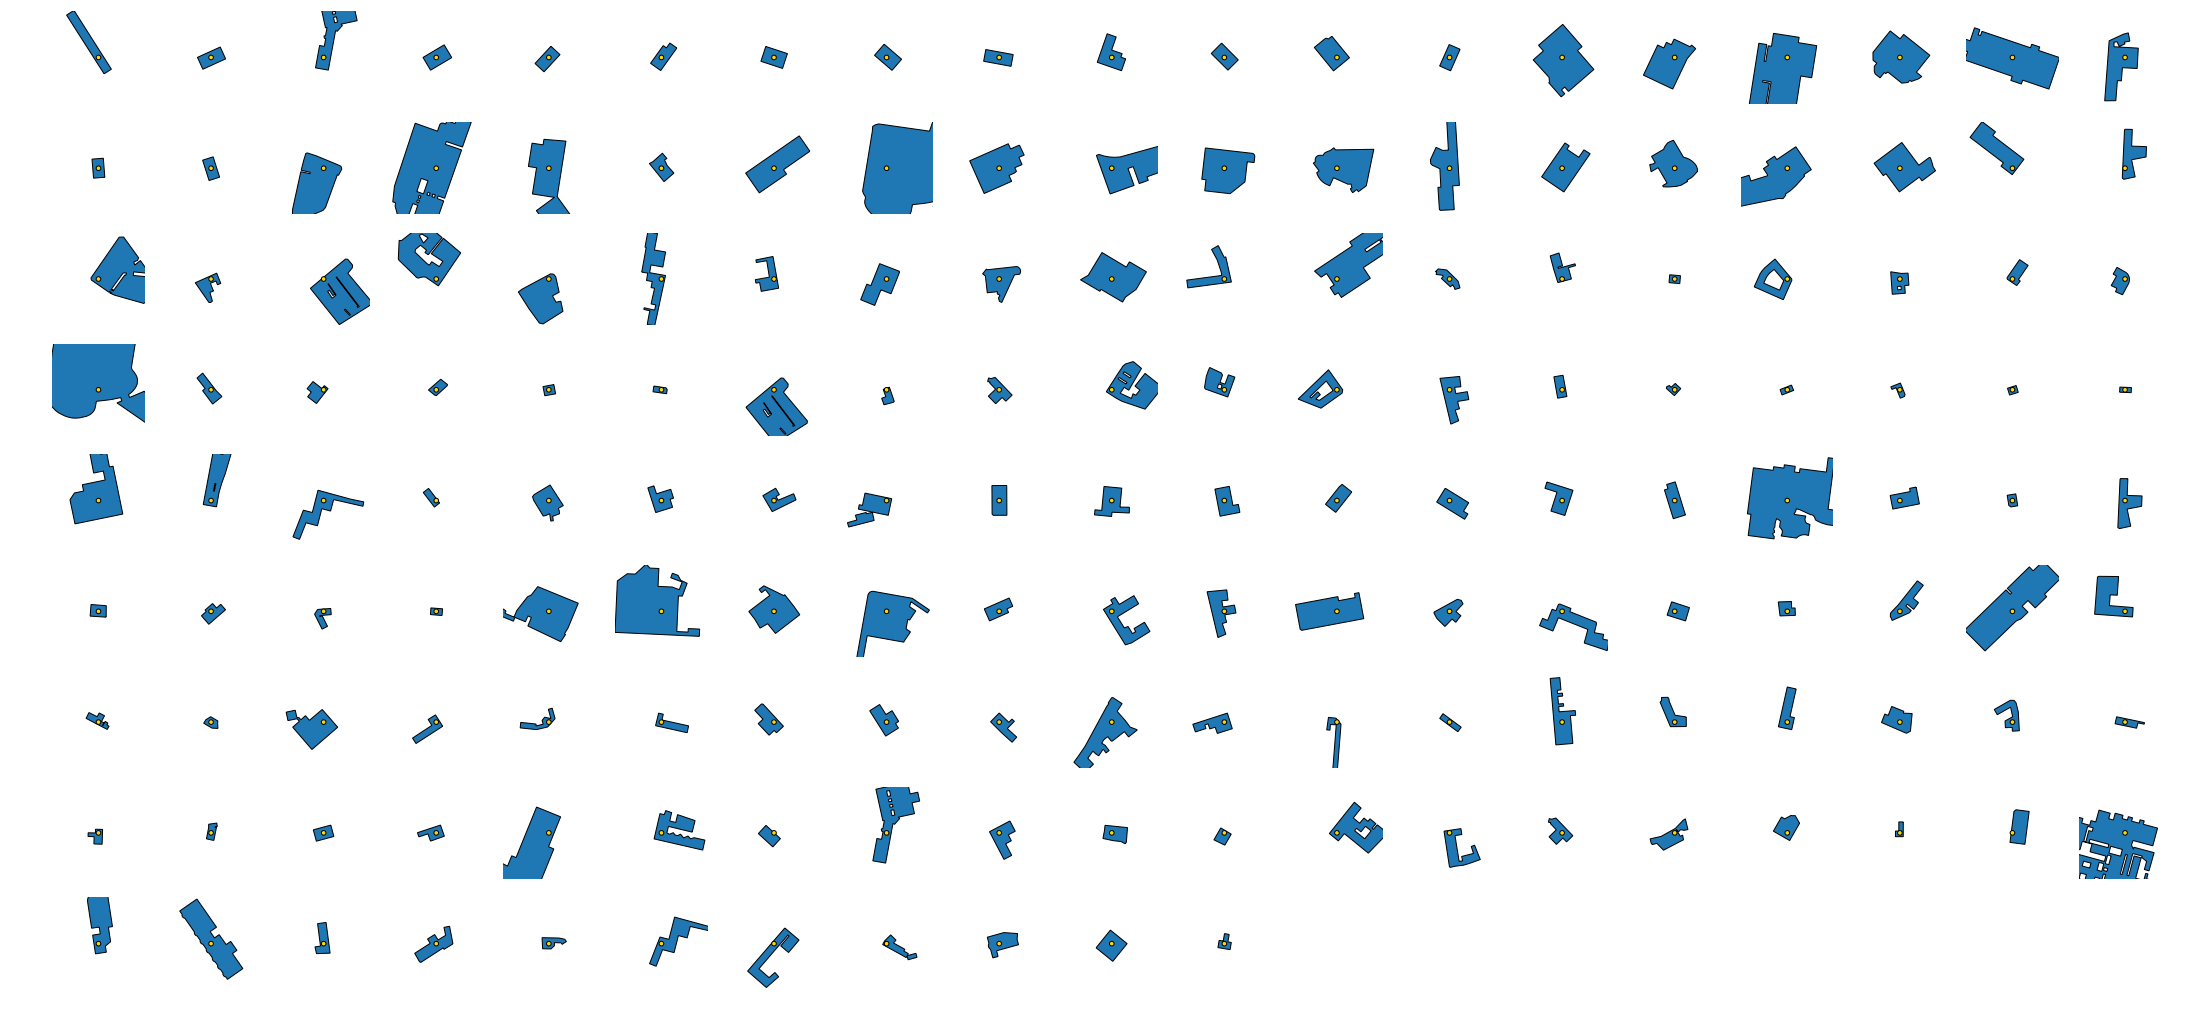

In [30]:
fig, axes = plt.subplots(9,19)
fig.set_size_inches(19*2, 9*2)

for i, ax in enumerate(axes.ravel()):
    
    if i < len(data_stores):
        ax.add_patch(PolygonPatch(data_stores.iloc[i]['building_poly']))
        ax.add_patch(PolygonPatch(data_stores.iloc[i]['geometry'].buffer(5), fc='gold'))

        xmin, ymin, xmax, ymax = data_stores.iloc[i]['geometry'].buffer(100).bounds
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)


    ax.set_aspect('equal', 'box')
    ax.set_axis_off()

# Store area and perimeter features

In [31]:
data_stores = (data_stores
               
 # Store Area
 .assign(store_perimeter = lambda x: x['building_poly'].apply(lambda poly: poly.boundary.length))
               
 # Store Perimeter
 .assign(store_area = lambda x: x['building_poly'].apply(lambda poly: poly.area))
               
 # Perimeter to Area Ratio
 .assign(perimeter_area_ratio = lambda x: x['store_perimeter']/x['store_area'])
)


    data_stores = (data_stores

     # Store Area
     .assign(store_perimeter = lambda x: x['building_poly'].apply(
                                      lambda poly: poly.boundary.length))

     # Store Perimeter
     .assign(store_area = lambda x: x['building_poly'].apply(
                                      lambda poly: poly.area))

     # Perimeter to Area Ratio
     .assign(perimeter_area_ratio = lambda x: x['store_perimeter']/x['store_area'])
    )


# Distance to station

In [32]:
# Add features distance to closest station
data_stores['distance_to_railway_station'] = data_stores.distance(railways)


    # Add features distance to closest station
    data_stores['distance_to_railway_station'] = data_stores.distance(railways)


# Distance to closest store

#### Finding the distance from each store to its closest other store

- Step 1: Create a shapely `multipoint` object
- Step 2: For each store, calculate its distance to the disjoint union of itself and all other points


In [33]:
stores = MultiPoint(data_stores['geometry'].values)

data_stores = data_stores.assign(
    distance_to_other_store = lambda x: x['geometry'].apply(lambda store: store.distance(stores.difference(store))))

    stores = MultiPoint(data_stores['geometry'].values)

    data_stores = data_stores.assign(
        distance_to_other_store = lambda x: x['geometry'].apply(
                lambda store: store.distance(stores.difference(store))))

# Closest Railway Station to each Store

In [34]:
data_stores = (data_stores
.assign(station_closest_name = lambda x: x['geometry'].apply(lambda p: 
                                          data_railways.loc[
                                              data_railways.distance(p).idxmin(), 'DISTNAME'
                                          ])
                                   )
               
 .assign(station_closest_type = lambda x: x['geometry'].apply(lambda p: 
                                           data_railways.loc[
                                               data_railways.distance(p).idxmin(), 'CLASSIFICA'
                                           ])
                                    ))



    data_stores = (data_stores
    .assign(station_closest_name = lambda x: x['geometry'].apply(lambda p: 
                              data_railways.loc[
                                  data_railways.distance(p).idxmin(), 'DISTNAME'
                              ])
                       )

     .assign(station_closest_type = lambda x: x['geometry'].apply(lambda p: 
                              data_railways.loc[
                                  data_railways.distance(p).idxmin(), 'CLASSIFICA'
                              ])
                       ))



## Are you the Store that is Closest to the Railway Station you are Closest to

In [35]:
# Add dummy indicating which store is closest by each of the stations
closeby = (data_stores
           .sort_values(['station_closest_name','distance_to_railway_station'])
           .drop_duplicates(['station_closest_name'], keep = 'first'))


data_stores['closest_to_station'] = data_stores['id'].isin(closeby['id'])


    # Add dummy indicating which store is closest by each of the stations
    closeby = (data_stores
               .sort_values(['station_closest_name','distance_to_railway_station'])
               .drop_duplicates(['station_closest_name'], keep = 'first'))


    data_stores['closest_by_any_station'] = data_stores['id'].isin(closeby['id'])

# How many other stores/stations are within 1km of each store?

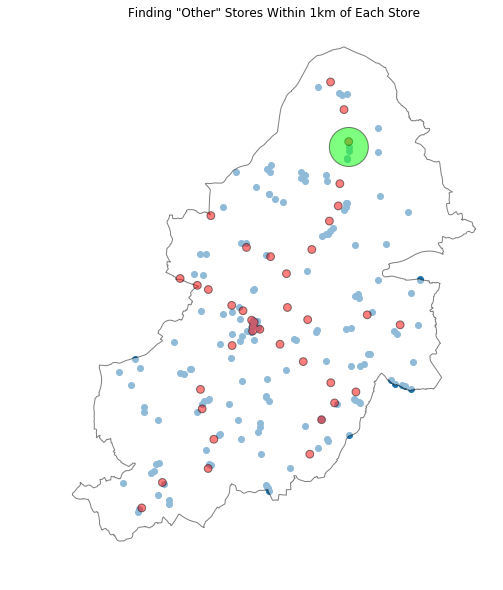

In [36]:
plt.figure(figsize=(10,10))
ax = plt.axes()
ax.set_axis_off()
ax.set_aspect('equal')


ax.add_patch(PolygonPatch(birmingham_polygon, facecolor=[1,1,1], edgecolor=[0,0,0], alpha=.5, zorder=2))
ax.add_patch(PolygonPatch(railways.buffer(200), facecolor=[1,0,0], edgecolor=[0,0,0], alpha=.5, zorder=2))

ax.scatter(x=[store.x for store in stores], y=[store.y for store in stores])

k=stores[22].buffer(1000)
ax.add_patch(PolygonPatch(k, facecolor=[0,1,0], edgecolor=[0,0,0], alpha=0.5, zorder=2))


ax.set_title('Finding "Other" Stores Within 1km of Each Store')
plt.show()

In [37]:
# Get the store locations
store_multipoint = MultiPoint(data_stores['geometry'].values)


data_stores['count_stores_within_1km'] = (data_stores['geometry'].apply(
        lambda p: p.buffer(1000).intersection(store_multipoint))
                                         .apply(lambda x: 0 if isinstance(x,Point) else len(x)-1))

data_stores['count_stations_within_1km'] = (data_stores['geometry'].apply(
        lambda p: p.buffer(1000).intersection(railways))
                                         .apply(lambda x: 1 if isinstance(x,Point) else len(x)))



    # Get the store locations
    store_multipoint = MultiPoint(data_stores['geometry'])


    data_stores['count_stores_within_1km'] = (data_stores['geometry'].apply(
            lambda p: p.buffer(1000).intersection(store_multipoint))
                         .apply(lambda x: 0 if isinstance(x,Point) else len(x)-1))

    data_stores['count_stations_within_1km'] = (data_stores['geometry'].apply(
            lambda p: p.buffer(1000).intersection(railways))
                         .apply(lambda x: 1 if isinstance(x,Point) else len(x)))

# The Final Data

In [38]:
data_stores.head(2)

,id,retailer,fascia,store_name,add_one,add_two,town,locality,postcode,long_wgs,lat_wgs,bng_e,bng_n,pqi,open_date,close_date,size_band,size_sqft,size_sqm,geometry,store_reviews,store_score,distance_to_railway_station,building_poly,store_perimeter,store_area,perimeter_area_ratio,distance_to_other_store,station_closest_name,station_closest_type,closest_to_station,count_stores_within_1km,count_stations_within_1km
0,1010000006,Aldi,Aldi,Aldi Sparkbrook Birmingham,273 Stratford Road,Sparkbrook,Birmingham,Sparkbrook,B11 1QS,-1.872444,52.459726,408764.05,284649.62,Rooftop geocoded by Geolytix,0,0,"3,013 < 15,069 ft2 (280 < 1,400 m2)","Between 3,013 and 15,069","Between 280 and 1,400",POINT (408764.05 284649.62),931,4.0,992.505699,"POLYGON Z ((408776.19 284614.18 0, 408694.9 28...",339.815249,2851.54005,0.119169,1072.611761,Small Heath,Railway Station,True,0,1
1,1010000007,Aldi,Aldi,Aldi Warstock Birmingham,Alcester Road,Maypole Lane,Birmingham,Warstock,B14 5JE,-1.886342,52.405415,407829.25,278606.87,Rooftop geocoded by Geolytix,0,0,"15,069 < 30,138 ft2 (1,400 < 2,800 m2)","Between 15,069 and 30,138","Between 1,400 and 2,800",POINT (407829.25 278606.87),894,4.1,2772.315293,"POLYGON Z ((407799.74 278607.09 0, 407849.12 2...",164.956756,1532.00310,0.107674,63.208279,Yardley Wood,Railway Station,False,3,0


#### Further feature ideas

- Add features distance to major road <br>
- Add data on population density
- Add data on travel frequency to different stations



# Some more EDA

In [39]:
data_stores.head()

,id,retailer,fascia,store_name,add_one,add_two,town,locality,postcode,long_wgs,lat_wgs,bng_e,bng_n,pqi,open_date,close_date,size_band,size_sqft,size_sqm,geometry,store_reviews,store_score,distance_to_railway_station,building_poly,store_perimeter,store_area,perimeter_area_ratio,distance_to_other_store,station_closest_name,station_closest_type,closest_to_station,count_stores_within_1km,count_stations_within_1km
0,1010000006,Aldi,Aldi,Aldi Sparkbrook Birmingham,273 Stratford Road,Sparkbrook,Birmingham,Sparkbrook,B11 1QS,-1.872444,52.459726,408764.05,284649.62,Rooftop geocoded by Geolytix,0,0,"3,013 < 15,069 ft2 (280 < 1,400 m2)","Between 3,013 and 15,069","Between 280 and 1,400",POINT (408764.05 284649.62),931,4.0,992.505699,"POLYGON Z ((408776.19 284614.18 0, 408694.9 28...",339.815249,2851.54005,0.119169,1072.611761,Small Heath,Railway Station,True,0,1
1,1010000007,Aldi,Aldi,Aldi Warstock Birmingham,Alcester Road,Maypole Lane,Birmingham,Warstock,B14 5JE,-1.886342,52.405415,407829.25,278606.87,Rooftop geocoded by Geolytix,0,0,"15,069 < 30,138 ft2 (1,400 < 2,800 m2)","Between 15,069 and 30,138","Between 1,400 and 2,800",POINT (407829.25 278606.87),894,4.1,2772.315293,"POLYGON Z ((407799.74 278607.09 0, 407849.12 2...",164.956756,1532.00310,0.107674,63.208279,Yardley Wood,Railway Station,False,3,0
2,1010000008,Aldi,Aldi,Aldi Aston Birmingham,High Street,Newtown,Birmingham,Aston,B19 2SS,-1.896935,52.496752,407094.15,288765.55,Rooftop geocoded by Geolytix,0,0,"3,013 < 15,069 ft2 (280 < 1,400 m2)","Between 3,013 and 15,069","Between 280 and 1,400",POINT (407094.15 288765.55),617,4.1,1189.968978,"POLYGON Z ((407178.04 288872.46 0, 407161.54 2...",649.685086,7393.78065,0.087869,39.993444,St Paul's,Light Rapid Transit Station,False,1,0
3,1010000009,Aldi,Aldi,Aldi Lyndon Green Birmingham,New Coventry Road,NaN,Birmingham,Lyndon Green,B26 3HP,-1.792907,52.454990,414169.89,284135.28,Rooftop geocoded by Geolytix,0,0,"3,013 < 15,069 ft2 (280 < 1,400 m2)","Between 3,013 and 15,069","Between 280 and 1,400",POINT (414169.89 284135.28),743,4.2,1913.554875,"POLYGON Z ((414203.52 284135 0, 414157.62 2841...",171.098754,1716.77780,0.099663,259.785278,Acocks Green,Railway Station,False,3,0
4,1010000010,Aldi,Aldi,Aldi Acocks Green Birmingham,Warwick Road,NaN,Birmingham,Acocks Green,B27 6RH,-1.816826,52.444672,412547.36,282983.19,Rooftop geocoded by Geolytix,0,0,"3,013 < 15,069 ft2 (280 < 1,400 m2)","Between 3,013 and 15,069","Between 280 and 1,400",POINT (412547.36 282983.19),636,4.2,589.914925,"POLYGON Z ((412551.95 283007.45 0, 412571.55 2...",154.956720,1354.55990,0.114396,35.563239,Acocks Green,Railway Station,False,3,1


In [40]:
data_eda= data_stores.select_dtypes(['int','float','bool']).drop(['id','long_wgs','lat_wgs','bng_e','bng_n','open_date','close_date'], axis=1)

    data_eda = (data_stores
                .select_dtypes(['int','float','bool'])
                .drop(['id','long_wgs','lat_wgs','bng_e','bng_n',
                       'open_date','close_date'], axis=1))


# Box plot
(to understand the scaling of our numeric features)

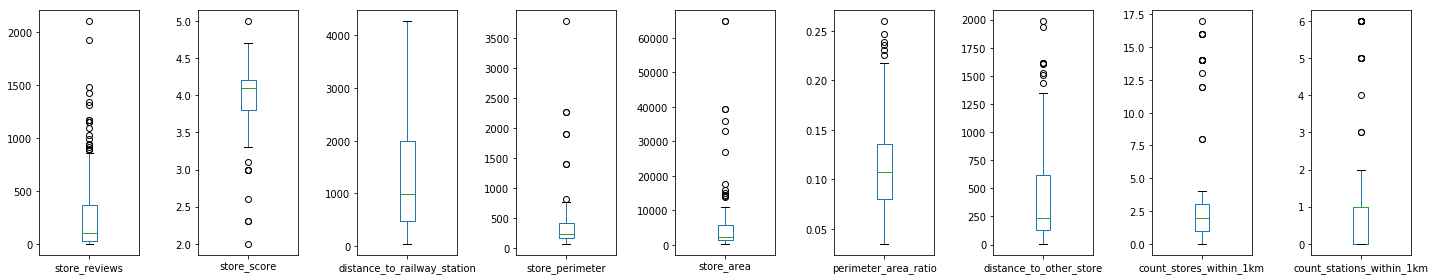

In [41]:
ax = pd.DataFrame(data_eda).plot(kind='box', subplots=True, figsize=(20,4))
plt.tight_layout()

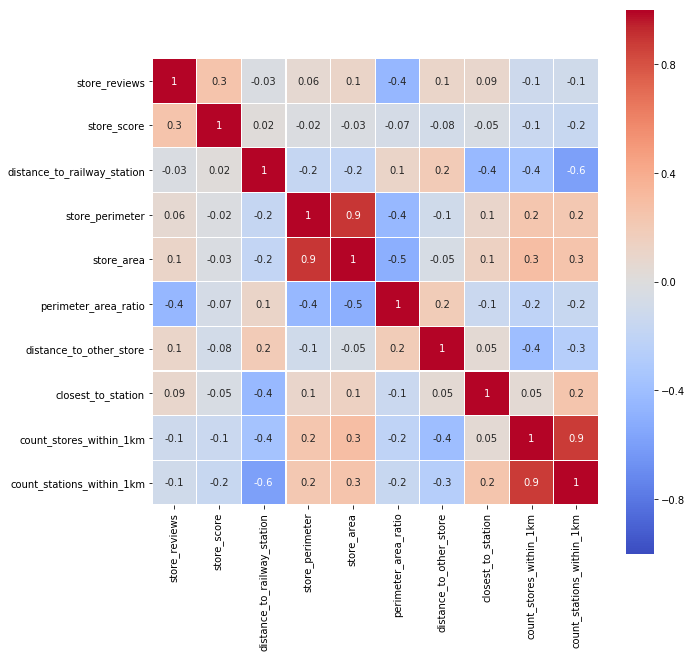

In [42]:
plt.figure(figsize=(10,10))
sns.heatmap(data_eda.corr(), linewidth=0.1, annot=True, square=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.1g')
plt.show()

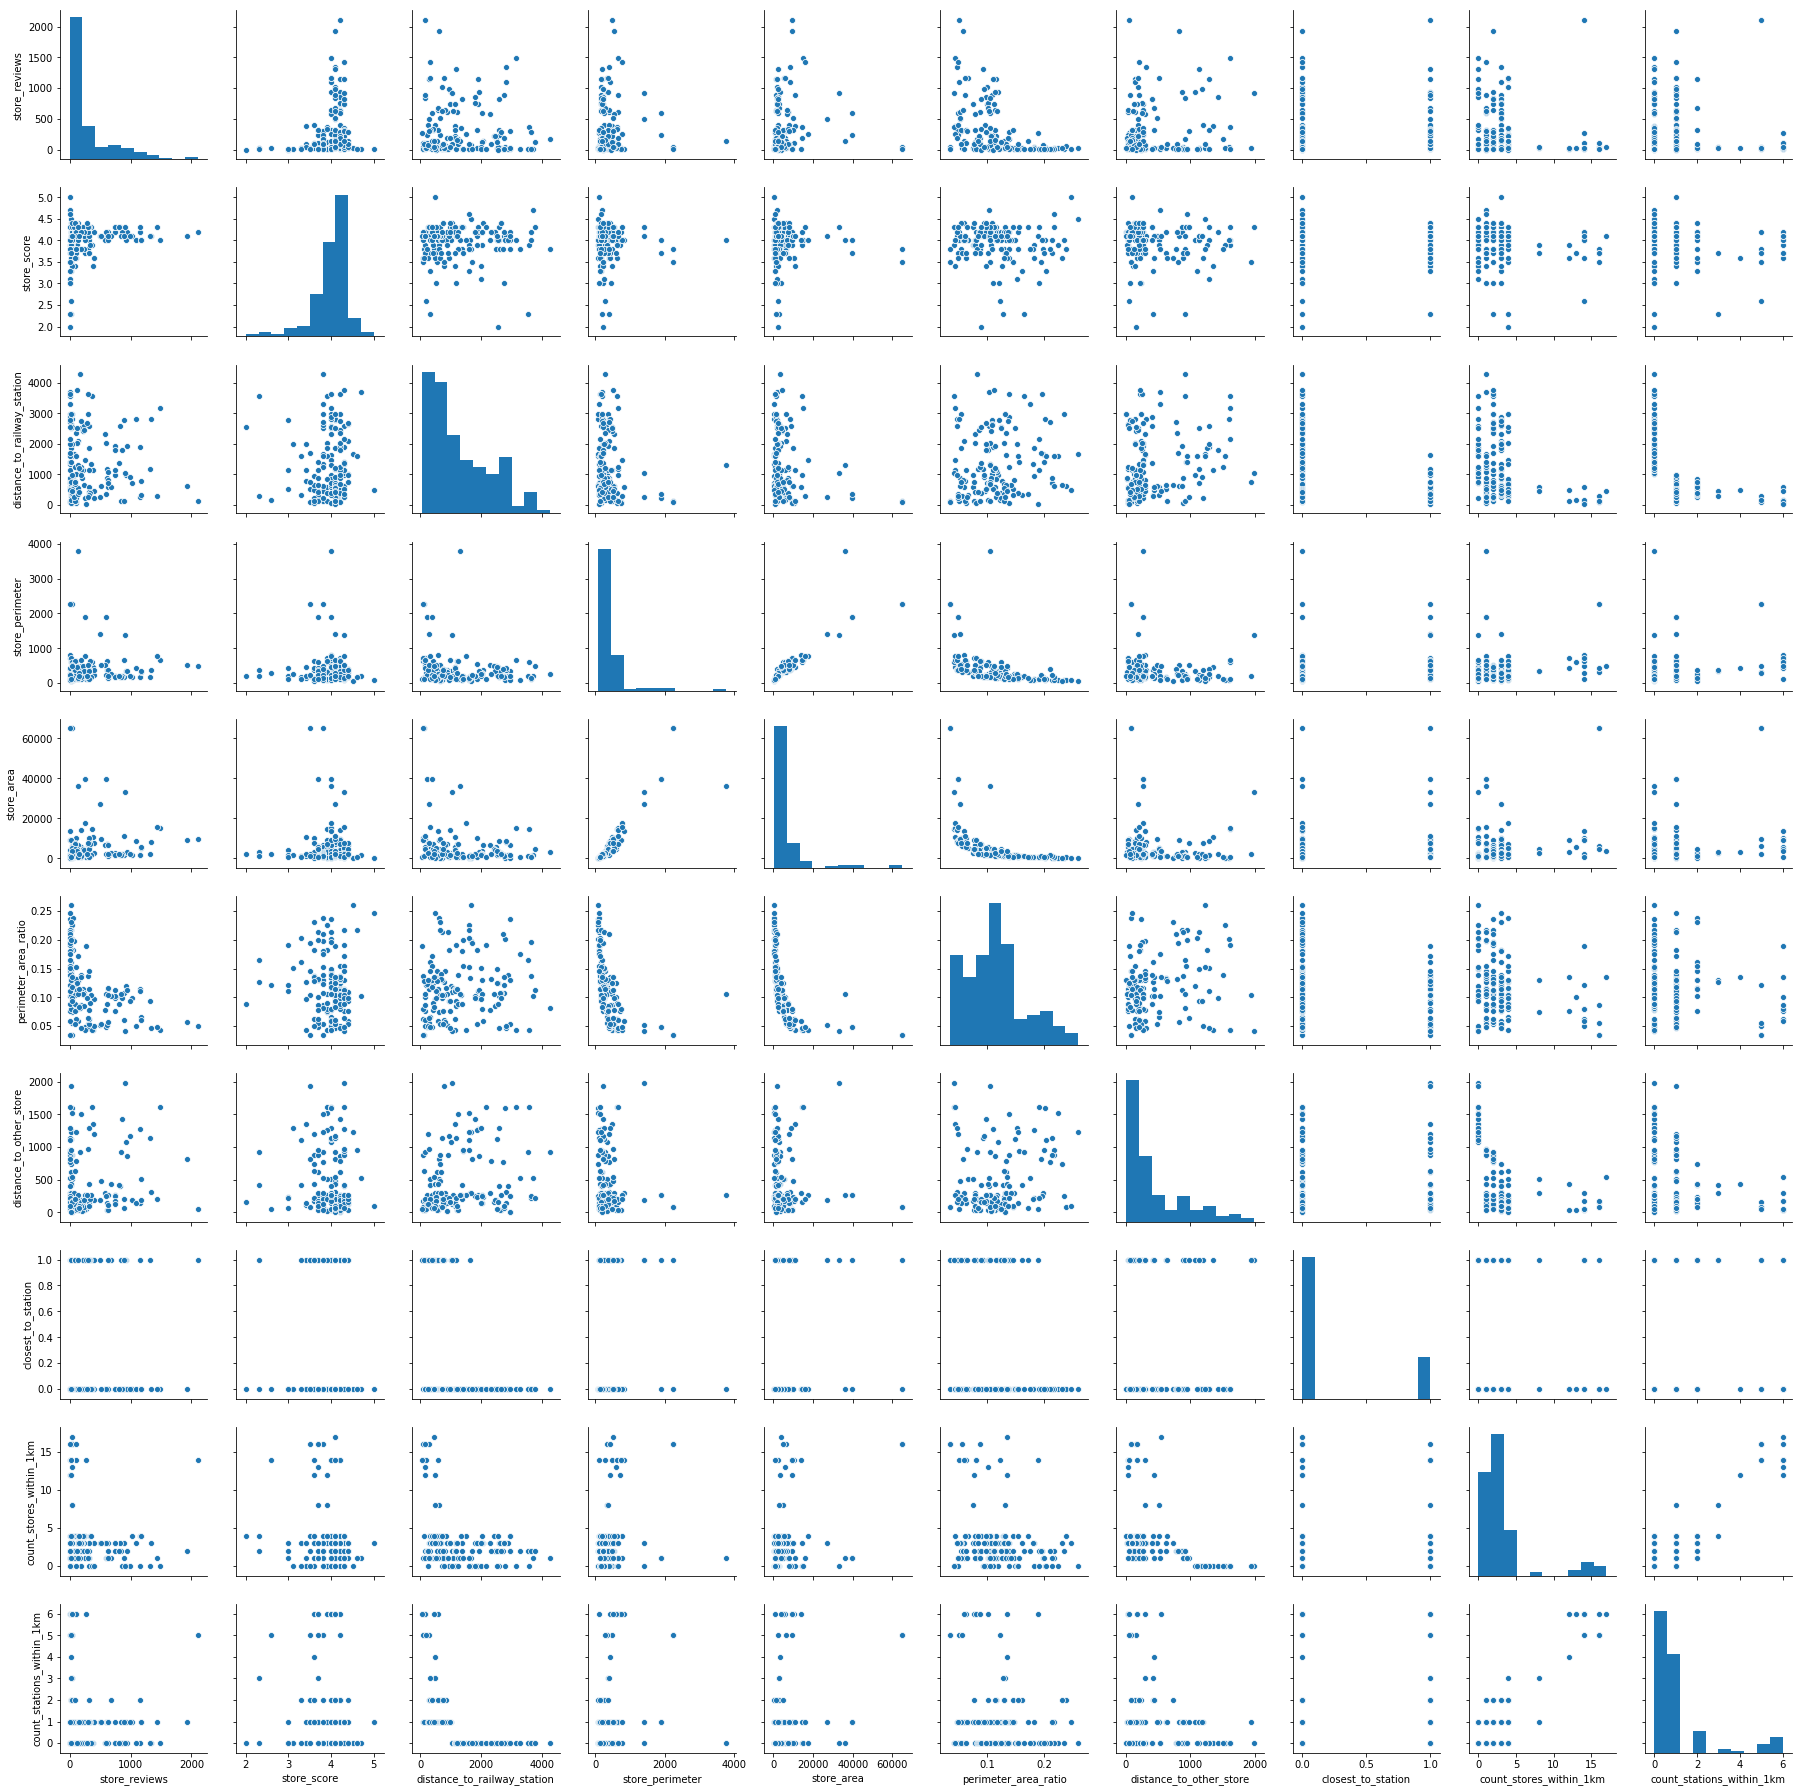

In [43]:
sns.pairplot(data_eda)

In [44]:
interesting_columns = ['store_reviews', 'store_score', 
                       'distance_to_railway_station',
                       'store_perimeter', 'store_area', 'perimeter_area_ratio',
                       'distance_to_other_store', 'closest_to_station',
                       'count_stores_within_1km', 'count_stations_within_1km']

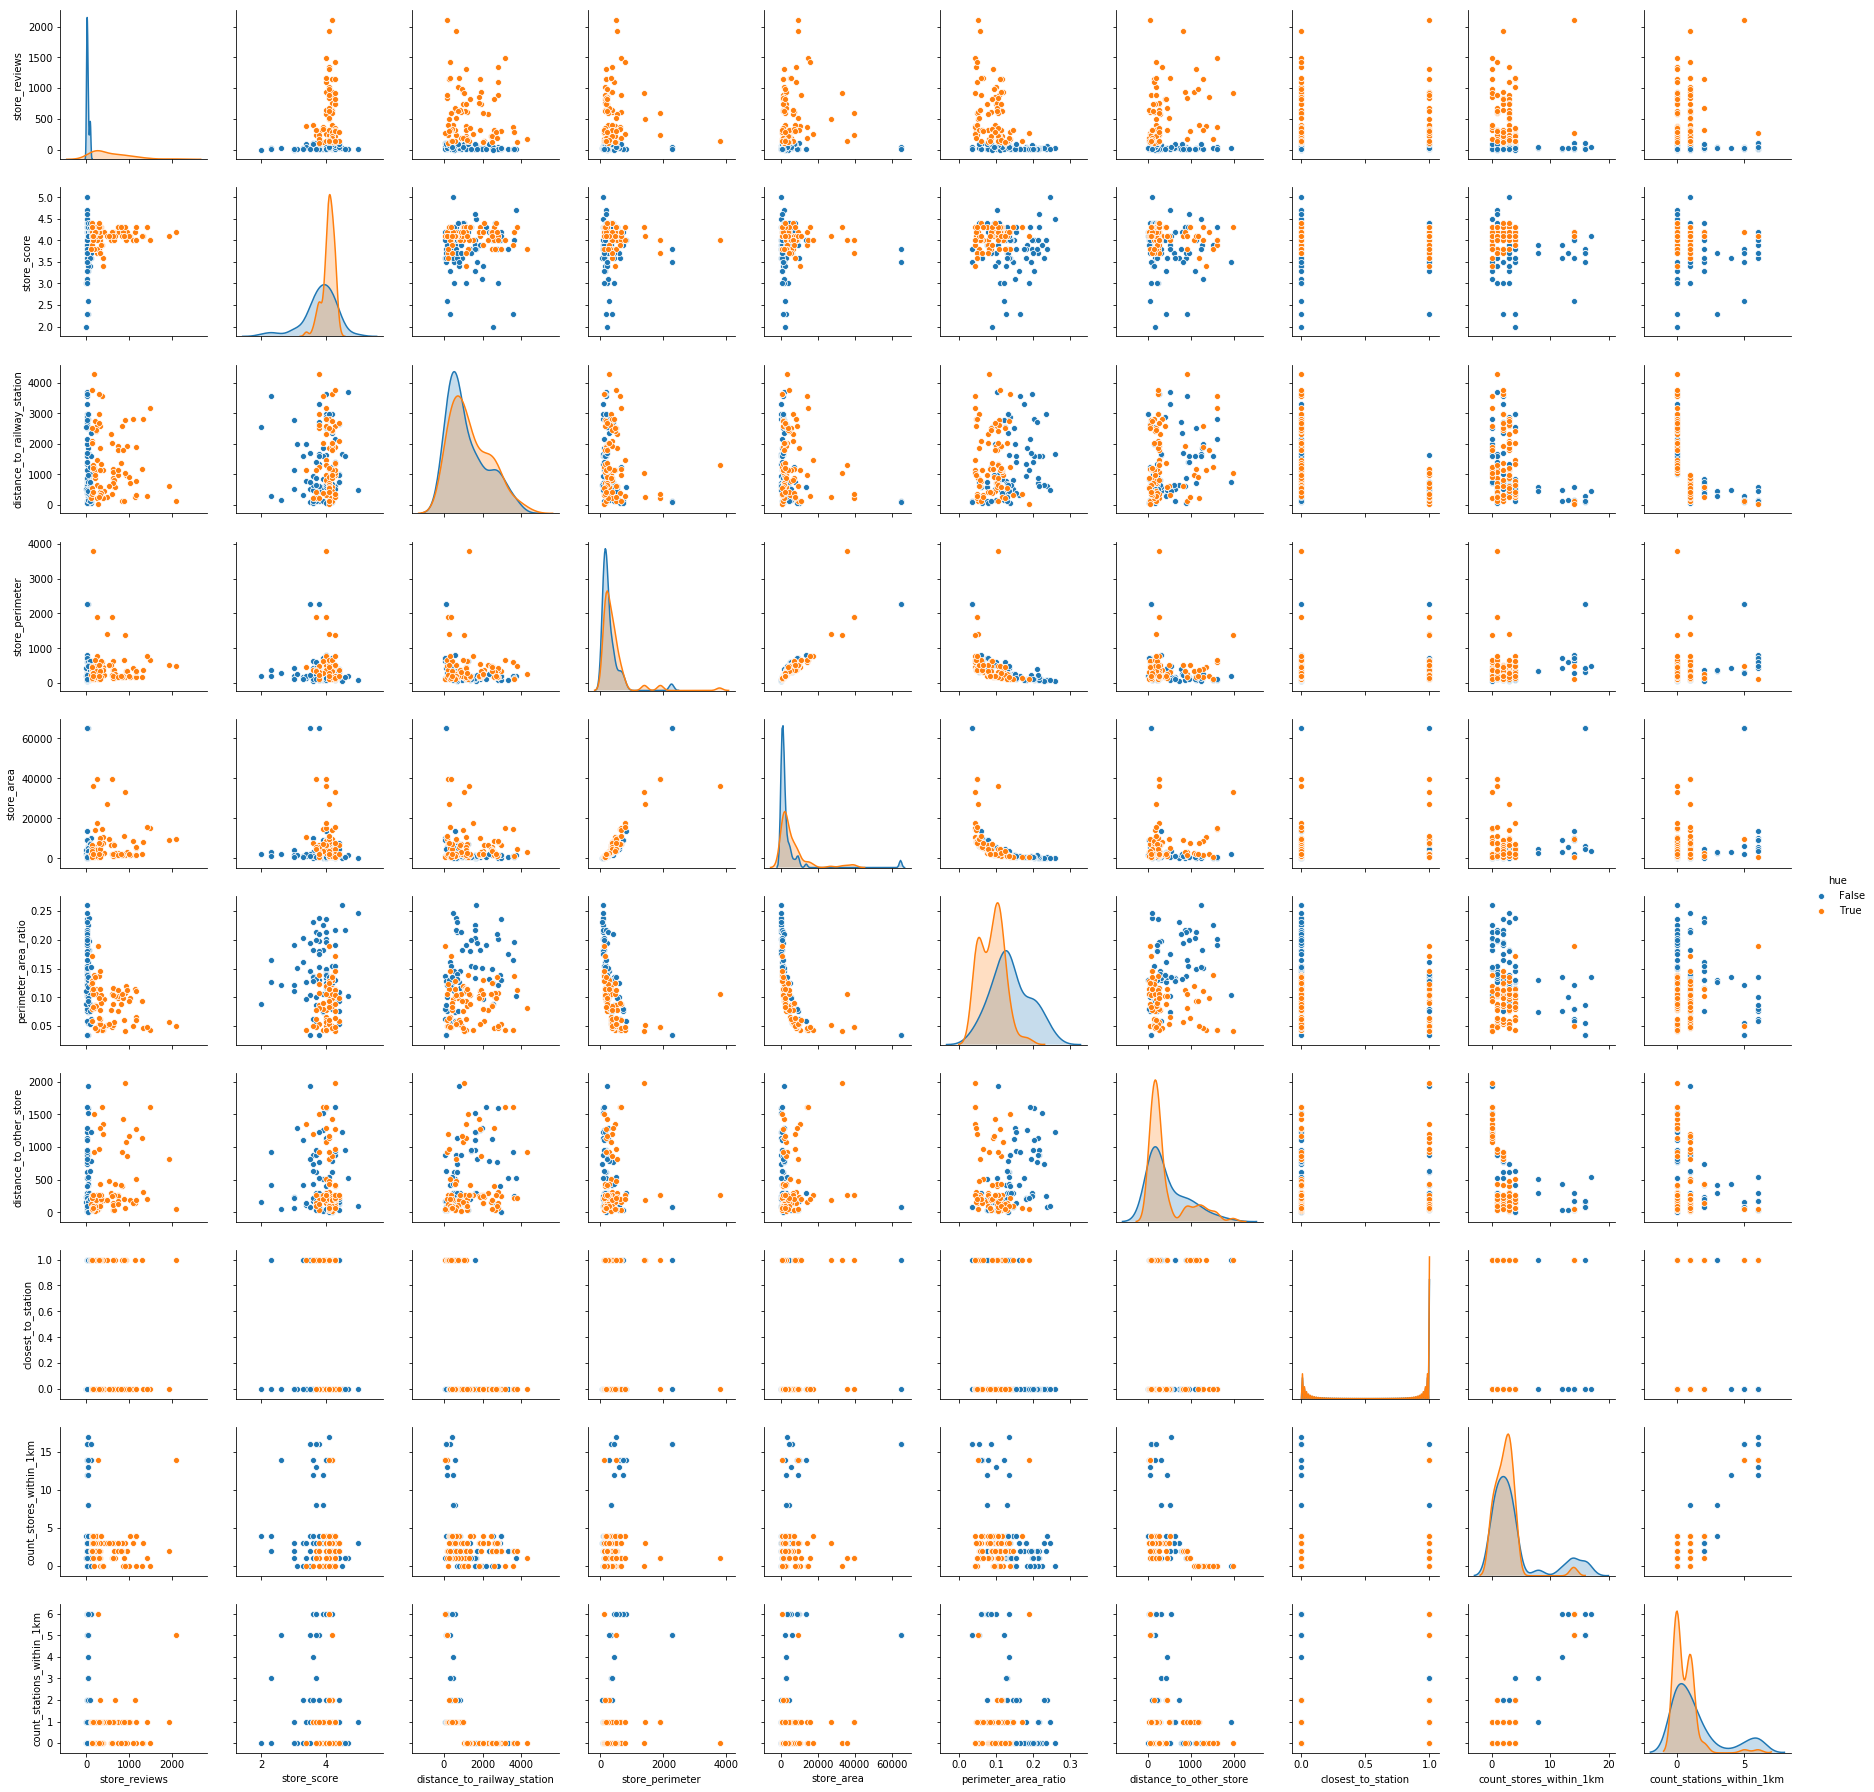

In [45]:
sns.pairplot(data_eda.assign(hue=lambda x: x['store_reviews']>data_eda['store_reviews'].median()), 
             vars=interesting_columns, hue='hue')

# Designing the target variable

To answer the business question, we need to define 'store success'. Ideally, we would be able to use a statistic like store revenue for this. However, in the business context we don't have access to retail sales data from competitors hence we cannot use this as a target variable. This means we need to think of a proxy. In our case, we decided to use Google Review data. In this context:

- The number of reviews is a proxy for the quantity of store visit. 
- The review score is a proxy for the quality of people their visit.

In [46]:
target = data_stores['store_reviews']**.5 * data_stores['store_score']

    target = data_stores['store_reviews']**.5 * data_stores['store_score']

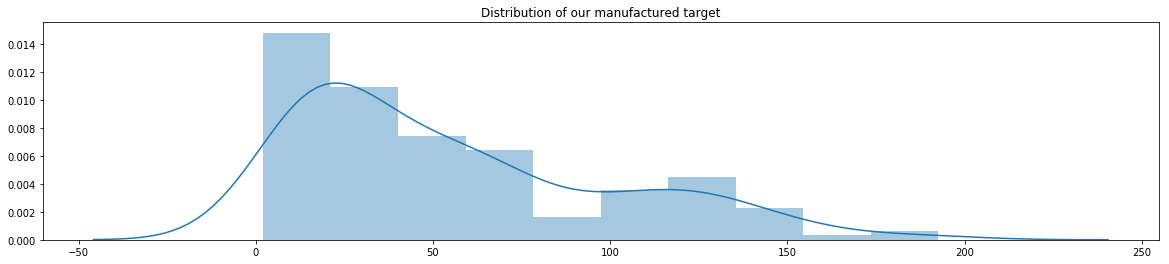

In [47]:
plt.figure(figsize=(20,4))
ax = sns.distplot(target)
ax.set_title('Distribution of our manufactured target')
plt.show()

In [48]:
y = (target > target.median()).map({True:'Better than average',False:'Worse than average'})

    y = (target > target.median()).map({True:'Better than average',False:'Worse than average'})

# Selecting the Predictors

    'retailer',
    'locality',
    'distance_to_railway_station',
    'store_perimeter',
    'store_area',
    'perimeter_area_ratio',
    'distance_to_other_store',
    'station_closest_name',
    'station_closest_type',
    'closest_to_station',
    'count_stores_within_1km',
    'count_stations_within_1km'

In [63]:
X = data_stores[
    ['retailer',
     'locality',
     'distance_to_railway_station',
     'store_perimeter',
     'store_area',
     'perimeter_area_ratio',
     'distance_to_other_store',
     'station_closest_name',
     'station_closest_type',
     'closest_to_station',
     'count_stores_within_1km',
     'count_stations_within_1km']]

X.head()

,retailer,locality,distance_to_railway_station,store_perimeter,store_area,perimeter_area_ratio,distance_to_other_store,station_closest_name,station_closest_type,closest_to_station,count_stores_within_1km,count_stations_within_1km
0,Aldi,Sparkbrook,992.505699,339.815249,2851.54005,0.119169,1072.611761,Small Heath,Railway Station,True,0,1
1,Aldi,Warstock,2772.315293,164.956756,1532.00310,0.107674,63.208279,Yardley Wood,Railway Station,False,3,0
2,Aldi,Aston,1189.968978,649.685086,7393.78065,0.087869,39.993444,St Paul's,Light Rapid Transit Station,False,1,0
3,Aldi,Lyndon Green,1913.554875,171.098754,1716.77780,0.099663,259.785278,Acocks Green,Railway Station,False,3,0
4,Aldi,Acocks Green,589.914925,154.956720,1354.55990,0.114396,35.563239,Acocks Green,Railway Station,False,3,1


In [50]:
X = pd.get_dummies(X, prefix_sep=' - ')
X.head()

,distance_to_railway_station,store_perimeter,store_area,perimeter_area_ratio,distance_to_other_store,closest_to_station,count_stores_within_1km,count_stations_within_1km,retailer - Aldi,retailer - Asda,retailer - Central England Co-operative,retailer - Costco,retailer - Farmfoods,retailer - Heron,retailer - Iceland,retailer - Lidl,retailer - Marks and Spencer,retailer - Midcounties Co-operative,retailer - Morrisons,retailer - Sainsburys,retailer - Tesco,retailer - The Co-operative Group,retailer - Waitrose,locality - Acocks Green,locality - Alum Rock,locality - Aston,locality - Bartley Green,locality - Bordesley,locality - Bournville,locality - Brandhall,locality - Brandwood,locality - Castle Bromwich,locality - Central Birmingham,locality - Edgbaston,locality - Erdington,locality - Great Barr,locality - Hall Green,locality - Handsworth,locality - Harborne,locality - Hodge Hill,locality - Kingstanding,locality - Longbridge,locality - Lyndon Green,locality - Mere Green,locality - Moseley,locality - Nechells,locality - New Oscott,locality - Northfield,locality - Old Oscott,locality - Perry Barr,locality - Quinton,locality - Rubery,locality - Selly Oak,locality - Sheldon,locality - Sparkbrook,locality - Sparkhill,locality - Stetchford,locality - Stirchley,locality - Sutton Coldfield,locality - Tyburn,locality - Walmley,locality - Warstock,locality - Weoley Castle,locality - Winson Green,locality - Witton,locality - Yardley,station_closest_name - Acocks Green,station_closest_name - Adderley Park,station_closest_name - Aston,station_closest_name - Birmingham Moor Street,station_closest_name - Birmingham New Street,station_closest_name - Birmingham Snow Hill,station_closest_name - Bordesley,station_closest_name - Bournville,station_closest_name - Bull Street,station_closest_name - Butlers Lane,station_closest_name - Chester Road,station_closest_name - Corporation Street,station_closest_name - Erdington,station_closest_name - Five Ways,station_closest_name - Four Oaks,station_closest_name - Hall Green,station_closest_name - Hamstead,"station_closest_name - Handsworth, Booth Street",station_closest_name - Jewellery Quarter,station_closest_name - Kings Norton,station_closest_name - Lea Hall,station_closest_name - Longbridge,station_closest_name - Northfield,station_closest_name - Perry Barr,station_closest_name - Selly Oak,station_closest_name - Small Heath,"station_closest_name - Soho, Benson Road",station_closest_name - Spring Road,station_closest_name - St Paul's,station_closest_name - Stechford,station_closest_name - Sutton Coldfield,station_closest_name - Tyseley,station_closest_name - University,"station_closest_name - Winson Green, Outer Circle",station_closest_name - Witton,station_closest_name - Wylde Green,station_closest_name - Yardley Wood,station_closest_type - Light Rapid Transit Station,station_closest_type - Light Rapid Transit Station And Railway Station,station_closest_type - Railway Station
0,992.505699,339.815249,2851.54005,0.119169,1072.611761,True,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2772.315293,164.956756,1532.00310,0.107674,63.208279,False,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
2,1189.968978,649.685086,7393.78065,0.087869,39.993444,False,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
3,1913.554875,171.098754,1716.77780,0.099663,259.785278,False,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4

# Machine Learning

When modelling data using machine learning algorithms, you can extract feature importances. Feature importances are an indication of how much variance each feature explains. Thus, the higher the feature importance the more insightful that particular feature is for store success. 

To be able to use the feature importances, we need to ensure that the model we build is highly accurate, in other words, we want the model to explain as much variance as possible. 

# Logistic Regression


In [51]:
from sklearn.metrics import accuracy_score


model_lr = Pipeline(steps=[
    ('ss', StandardScaler()),
    ('lr', LogisticRegression(penalty='l1', C=10))
])

model_lr.fit(X, y)

y_pred = cross_val_predict(model_lr, X, y, cv=10)


print(f'Accuracy: {int(accuracy_score(y, y_pred)*100)}%')

Accuracy: 79%


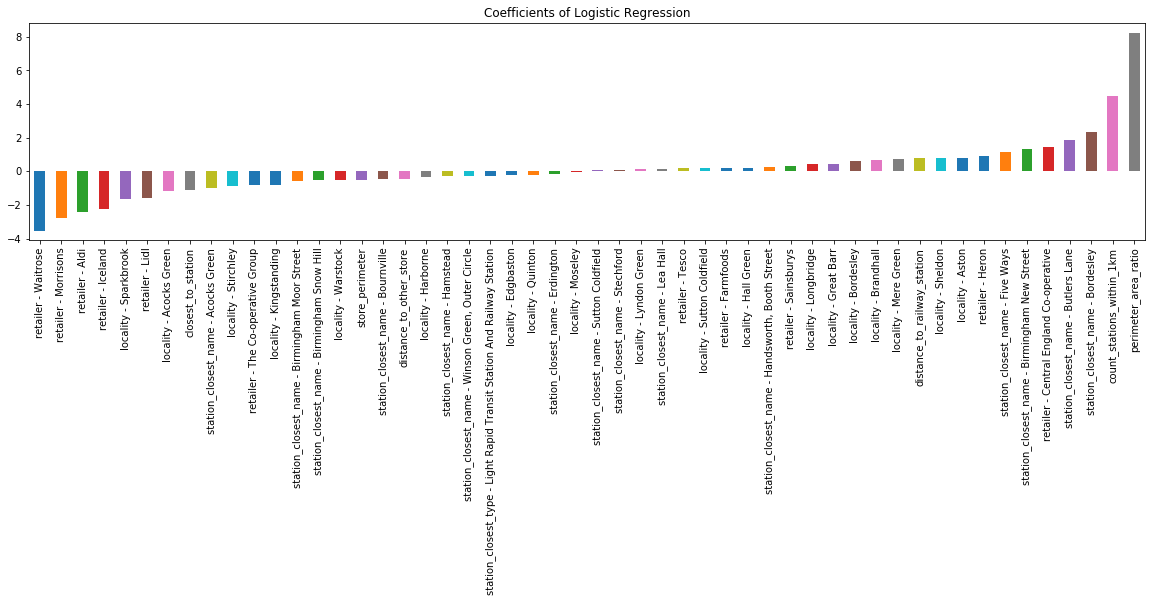

In [52]:
(pd.Series(model_lr.named_steps['lr'].coef_[0], index=X.columns)
 .mask(lambda x: x==0)
 .dropna()
 .sort_values()
 #.iloc[list(range(20))+list(range(-20,0))]
 .plot(kind='bar', figsize=(20,4), title='Coefficients of Logistic Regression'))

plt.show()

# Decision Tree

In [53]:
model_dtc = Pipeline(steps=[
    ('dtc', DecisionTreeClassifier(max_depth=3))
])

model_dtc.fit(X, y)

y_pred = cross_val_predict(model_dtc, X, y, cv=10)

print(f'Accuracy: {int(accuracy_score(y, y_pred)*100)}%')

Accuracy: 84%


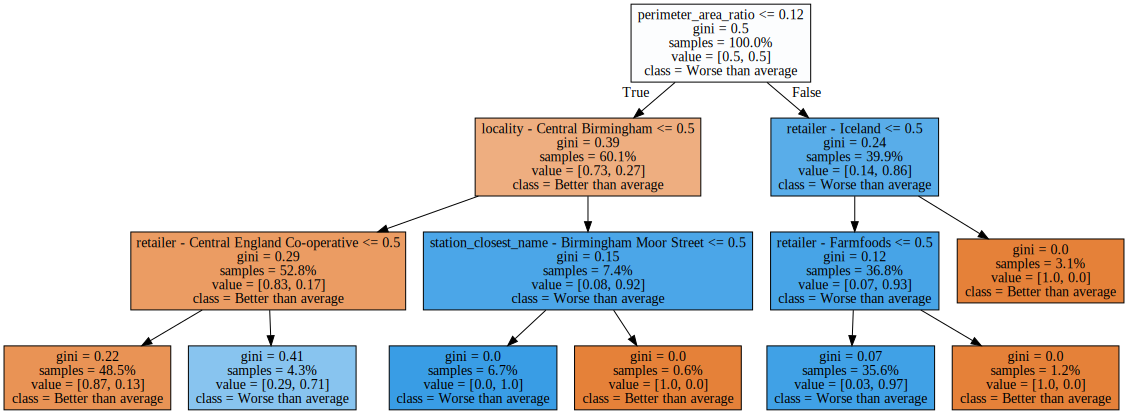

In [54]:
import graphviz
from sklearn.tree import export_graphviz
graphviz.Source(
    export_graphviz(
        model_dtc.named_steps['dtc'], 
        out_file=None, 
        feature_names=X.columns, 
        filled=True, 
        proportion=True, 
        precision=2, 
        class_names=model_dtc.named_steps['dtc'].classes_)
)

# Feature Importance with Random Forest

In [55]:
model_rfc = Pipeline(steps=[
    ('rfc', RandomForestClassifier(max_depth=3, n_estimators=200, random_state=2))
])

model_rfc.fit(X, y)

y_pred = cross_val_predict(model_rfc, X, y, cv=10)

print(f'Accuracy: {int(accuracy_score(y, y_pred)*100)}%')

Accuracy: 82%


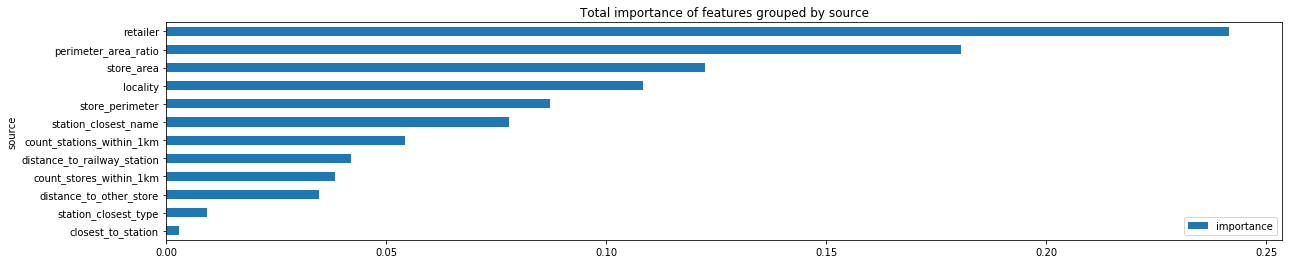

In [56]:
def plot_feature_importance(model, X, kwargs={}):
    feature_importance = pd.Series(model.feature_importances_, index=X.columns)

    feature_importance_groups = pd.DataFrame(
        data=[feature_importance.values, 
              [feat.split(' - ')[0] if ' - ' in feat else feat for feat in feature_importance.index]]
    ).T

    feature_importance_groups = feature_importance_groups.applymap(lambda x:'Other' if x == '_' else x)
    feature_importance_groups.columns = ['importance','source'] 

    (feature_importance_groups
     .groupby('source')
     .sum()
     .sort_values(by='importance')
     .plot(kind = 'barh', title = "Total importance of features grouped by source", **kwargs))
    
plot_feature_importance(model_rfc.named_steps['rfc'], X, kwargs=dict(figsize=(20,4)))

# From model to insights

We now have a highly accurate model that can identify locations that are likely to be successful supermarkets. However, to help drive business change it is important to convey what the model is doing in a way the client can understand, agree, and implement.

To tease out one insight, why is the perimeter to area ratio so important?

# Exploring high perimeter to area ratio

Let's plot the 16 buildings with the highest 

    perimeter_area_ratio 


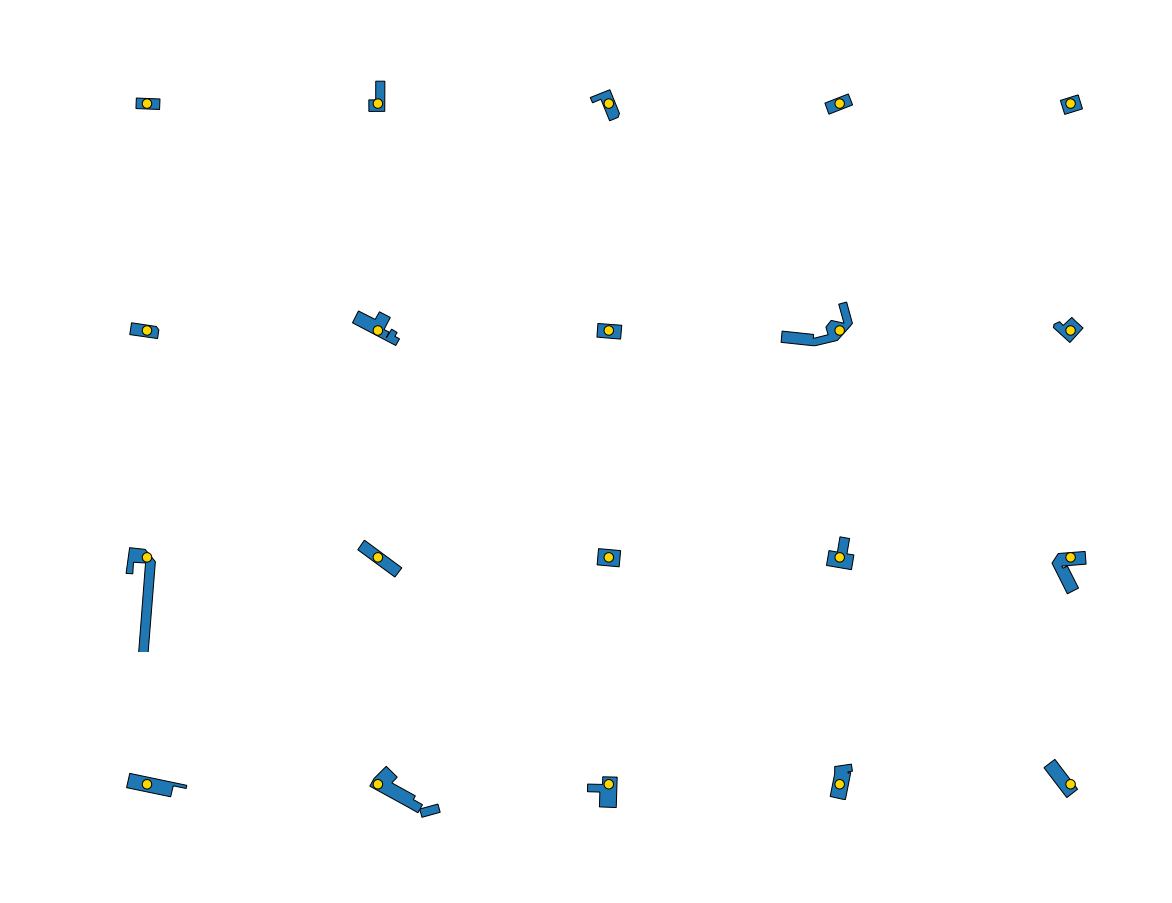

In [57]:
fig, axes = plt.subplots(4,5)
fig.set_size_inches(20, 16)

for i, ax in enumerate(axes.ravel()):
    
    ax.add_patch(PolygonPatch(data_stores.sort_values(by='perimeter_area_ratio', ascending=False).iloc[i]['building_poly']))
    ax.add_patch(PolygonPatch(data_stores.sort_values(by='perimeter_area_ratio', ascending=False).iloc[i]['geometry'].buffer(5), fc='gold'))

    xmin, ymin, xmax, ymax = data_stores.sort_values(by='perimeter_area_ratio', ascending=False).iloc[i]['geometry'].buffer(100).bounds
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)


    ax.set_aspect('equal', 'box')
    ax.set_axis_off()
    


How do these compare to the one's that have the lowest perimeter to area ratio?

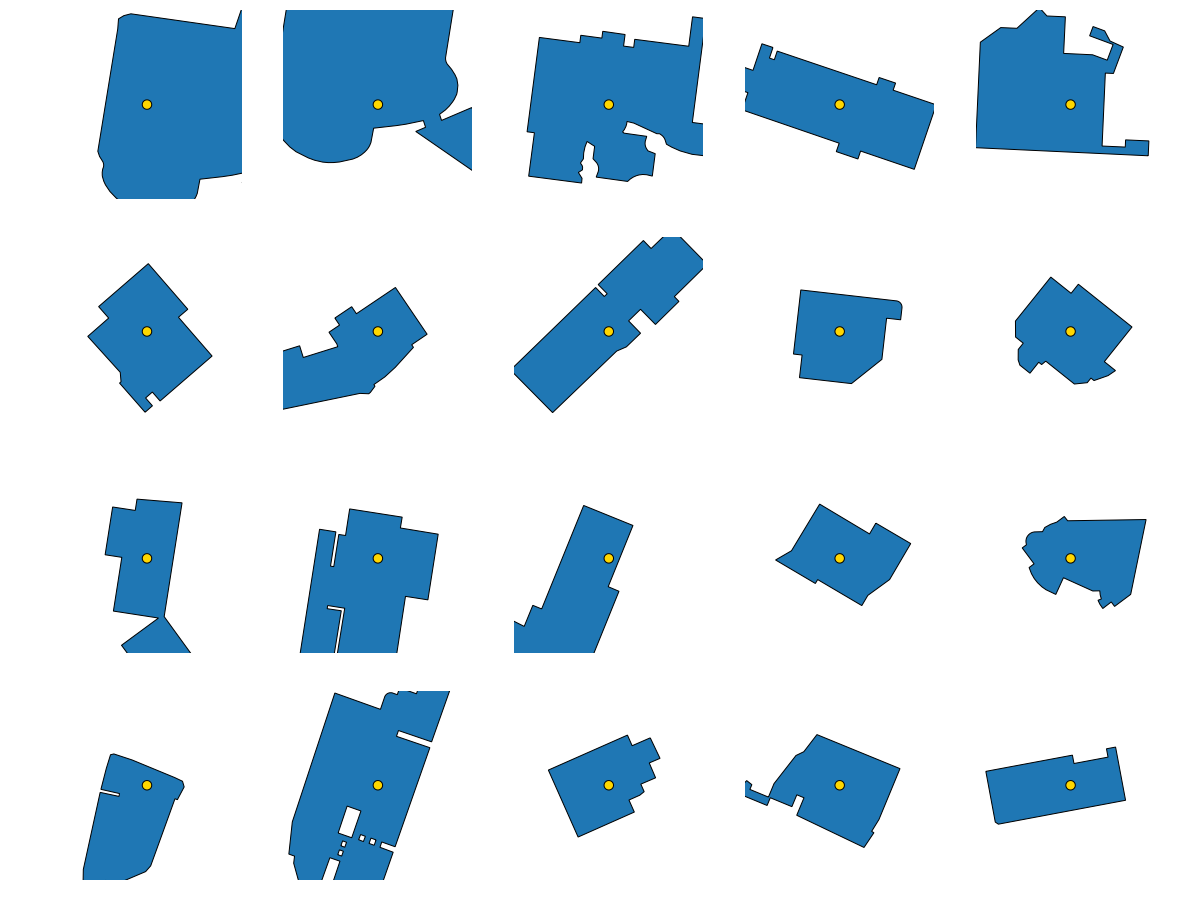

In [58]:
fig, axes = plt.subplots(4,5)
fig.set_size_inches(20, 16)

for i, ax in enumerate(axes.ravel()):
    
    ax.add_patch(PolygonPatch(data_stores.sort_values(by='perimeter_area_ratio', ascending=True).iloc[i]['building_poly']))
    ax.add_patch(PolygonPatch(data_stores.sort_values(by='perimeter_area_ratio', ascending=True).iloc[i]['geometry'].buffer(5), fc='gold'))

    xmin, ymin, xmax, ymax = data_stores.sort_values(by='perimeter_area_ratio', ascending=True).iloc[i]['geometry'].buffer(100).bounds
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)


    ax.set_aspect('equal', 'box')
    ax.set_axis_off()

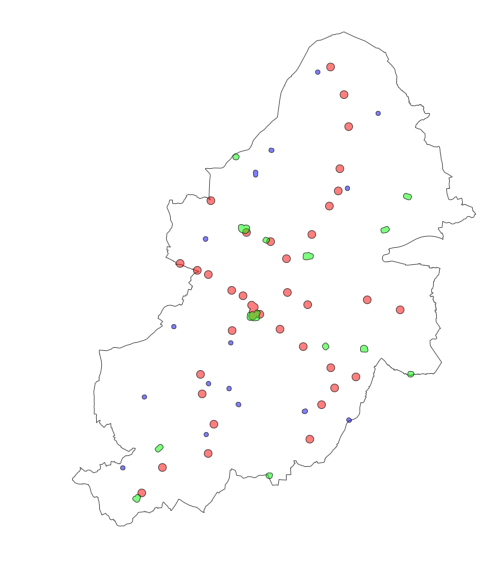

In [59]:
plt.figure(figsize=(10,10))
ax = plt.axes()
ax.set_axis_off()
ax.set_aspect('equal')

small_stores = data_stores.sort_values(by='perimeter_area_ratio', ascending=False).head(16)
big_stores = data_stores.sort_values(by='perimeter_area_ratio', ascending=True).head(16)

small_stores = MultiPolygon(list(small_stores['building_poly'].values))
big_stores = MultiPolygon(list(big_stores['building_poly'].values))

ax.add_patch(PolygonPatch(birmingham_polygon, facecolor=[1,1,1], edgecolor=[0,0,0], alpha=.5, zorder=2))
ax.add_patch(PolygonPatch(railways.buffer(200), facecolor=[1,0,0], edgecolor=[0,0,0], alpha=.5, zorder=2))

ax.add_patch(PolygonPatch(big_stores.buffer(100), facecolor=[0,1,0], edgecolor=[0,0,0], alpha=.5, zorder=2))
ax.add_patch(PolygonPatch(small_stores.buffer(100), facecolor=[0,0,1], edgecolor=[0,0,0], alpha=.5, zorder=2))

ax.scatter(x=[store.x for store in stores], y=[store.y for store in stores], alpha=0)


plt.show()

# Next steps


1. Listen for feedback from the client
2. Discuss how this could be put into practice
3. Scale this to a bigger dataset
4. Improve underlying results
